# Homework 2: CNN+RNN for video action recognition

Video classification for action recognition

Original code from https://github.com/aminullah6264/Pytorch-Action-Recognition/tree/master

## Dataset: UCF YouTube Action Data Set

Input is a video.

It contains 11 action categories: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.

https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

## Network: CNN + LSTM

1. Each frame in a video is an image. Apply a pre-trained Resnet encoder to each video frame separately. The result is a sequence of feature vectors.
2. Use the sequence of feature vectors as an input to an LSTM, configured as many-to-one. The result is a single feature vector.
3. Use a dense layer and softmax for the classification result (Class probabilities)

![](https://drive.google.com/uc?export=view&id=1__THInD1anw6dM0TSpyTz3DaB92QuKV0)



![](https://drive.google.com/uc?export=view&id=19YldS0u76k06iZAxk9FSKZsKvMkSj6a1)



In [1]:
# !pip install icecream
# !pip install torchinfo
# !pip install imageio
# !pip install -q git+https://github.com/tensorflow/docs
# !pip install torcheval
# !pip install gdown

!pip install -q icecream git+https://github.com/tensorflow/docs gdown

In [2]:
# Download the videos
!gdown --i 17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM

# !unzip -o /content/Videos_Youtube_val.zip
!unzip -o -q ./Videos_Youtube_val.zip

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM
From (redirected): https://drive.google.com/uc?id=17PwxdEfz0KxUWA0ifteJjv8DQphEbcPM&confirm=t&uuid=7c2c10e8-4b81-42ae-b676-a43cb4fe2dbd
To: /kaggle/working/Videos_Youtube_val.zip
100%|████████████████████████████████████████| 631M/631M [00:27<00:00, 23.2MB/s]


In [3]:
import gc
import os
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models

from torchinfo import summary

from torchmetrics.classification import (MulticlassAccuracy, 
                                         MulticlassF1Score)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imageio

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             ConfusionMatrixDisplay, 
                             f1_score)

from icecream import ic

from tensorflow_docs.vis import embed

from tqdm.auto import trange, tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%config InlineBackend.figure_format = "retina"

## Define experiment parameters

In [4]:
config = {
    'seed': 150,
    'train_batch_size': 64,
    'learning_rate': 1e-3,
    'epochs': 100,
    'patience': 10,
    'num_frames': 15,      # define the number of frames to extract features from (More frames = more temporal context)
    'use_convlstm': True,
    'hidden_size': 64,
    'num_layers': 1,
    # 'bidirectional': True, # only for LSTMClassifier
    'step_size': 30, 
    'gamma':0.1,
}


## Reproducibility

In [5]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(config['seed'])  

## Define the encoder

1. Get the resnet18 pretrained encoder from torchvision library. See the documentation https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
2. Remove the last layer (The final fully-connected layer responsible for image classification)

![](https://drive.google.com/uc?export=view&id=1db2Fws39VheIQmg3rqulwgNTwXZXiMdO)


![](https://drive.google.com/uc?export=view&id=1UNaMMWaebhEeCJuYGkVtwPQuFkKs_TXP)




## Encoder for LSTM:

![](https://drive.google.com/uc?export=view&id=1W3WOgF0uyCfqgJcVDDXrfuKfIL7SWPgx)



## Encoder for ConvLSTM (Before global average pooling):

![](https://drive.google.com/uc?export=view&id=1ZAKDLIqX8fdqCqPHa9OCCEJj5d69XDSj)


In [6]:
# Define the pre-processing steps for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pre-trained ResNet50 model (Torchvision) (Imagenet weights)
resnet = models.resnet18(weights='DEFAULT').cuda()

if config['use_convlstm'] == False:
    resnet_layer_idx = -1
elif config['use_convlstm'] == True:
    resnet_layer_idx = -2

# Remove the last layer of the ResNet50 model to obtain the feature extractor
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:resnet_layer_idx])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


## Extract encoder features

In [7]:
def extract_encoder_features(data_dir):

    # Create an empty list to store the features and labels
    samples = []
    resnet.eval()
    
    # Loop over the videos in the dataset folder
    video_paths = []
    sample_label_name = []

    class_count = 0
    samples_per_class_count = 0
    samples_per_class_counts = []
    for label in tqdm(os.listdir(data_dir)):
        label_dir = os.path.join(data_dir, label)
        class_count = class_count + 1
        samples_per_class_count = 0
        
        for sub_dir in os.listdir(label_dir):
            if sub_dir == 'Annotation':
                continue
            video_dir = os.path.join(label_dir, sub_dir)
        
            for video_file in os.listdir(video_dir):
                samples_per_class_count = samples_per_class_count + 1
                video_path = os.path.join(video_dir, video_file)
                cap = cv2.VideoCapture(video_path)

                frame_count = 0
                frames = []
                while True:
                    ret, frame = cap.read()
                    if ret:
                        frame_count += 1
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = transform(frame).cuda()
                        frames.append(frame)
                        if frame_count == config['num_frames']:
                            break
                    else:
                        break
                cap.release()

                if len(frames) == config['num_frames']:

                    # Stack the frames into a tensor of shape (num_frames=15, 3, 224, 224)
                    frames_tensor = torch.stack(frames, dim=0) # frames_tensor shape: (num_frames=15, 3, 224, 224)
                    # Extract the features using the pre-trained ResNet50 model
                    with torch.no_grad():
                        features_tensor = resnet_feat(frames_tensor) # features_tensor shape: (num_frames=15, feature_size=512, 7, 7) if use_convlstm else (num_frames=15, feature_size=512, 1, 1)

                    # Flatten the features tensor
                    if config['use_convlstm'] == False:
                        features_tensor = torch.flatten(features_tensor, start_dim=1) # features_tensor shape: (num_frames=15, feature_size=512)

                    # Convert the features tensor to a numpy array
                    features = features_tensor.cpu().numpy()
                    
                    # Append the features and label to the samples list
                    samples.append((features, label))
                    video_paths.append(video_path)
                    sample_label_name.append(label)
        print(f"Class: {label}, count: {samples_per_class_count}")
        samples_per_class_counts.append(samples_per_class_count)
        
    return samples, video_paths, sample_label_name, samples_per_class_counts

In [8]:
# Define the file path to your dataset
data_dir_train = './Videos/Train'
data_dir_test = './Videos/Test'
data_dir_validation = './Videos/Validation'

In [9]:
%%time

train_samples, _, _, count_per_class_train = extract_encoder_features(data_dir_train)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: golf_swing, count: 81
Class: swing, count: 148
Class: biking, count: 86
Class: horse_riding, count: 119
Class: diving, count: 107
Class: walking, count: 80
Class: soccer_juggling, count: 94
Class: basketball, count: 82
Class: volleyball_spiking, count: 80
Class: tennis_swing, count: 112
Class: trampoline_jumping, count: 78
CPU times: user 1min 39s, sys: 3.36 s, total: 1min 43s
Wall time: 50.2 s


In [10]:
%%time

validation_samples, _, _, count_per_class_validation = extract_encoder_features(data_dir_validation)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: golf_swing, count: 27
Class: swing, count: 18
Class: biking, count: 26
Class: horse_riding, count: 29
Class: diving, count: 19
Class: walking, count: 21
Class: soccer_juggling, count: 29
Class: basketball, count: 24
Class: volleyball_spiking, count: 16
Class: tennis_swing, count: 25
Class: trampoline_jumping, count: 19
CPU times: user 21.8 s, sys: 275 ms, total: 22 s
Wall time: 11 s


In [11]:
%%time

test_samples, video_paths_test, sample_label_name, count_per_class_test = extract_encoder_features(data_dir_test)

  0%|          | 0/11 [00:00<?, ?it/s]

Class: golf_swing, count: 34
Class: swing, count: 25
Class: biking, count: 33
Class: horse_riding, count: 50
Class: diving, count: 30
Class: walking, count: 22
Class: soccer_juggling, count: 33
Class: basketball, count: 35
Class: volleyball_spiking, count: 20
Class: tennis_swing, count: 30
Class: trampoline_jumping, count: 22
CPU times: user 28.5 s, sys: 341 ms, total: 28.9 s
Wall time: 14.4 s


In [12]:
count_per_class_train

[81, 148, 86, 119, 107, 80, 94, 82, 80, 112, 78]

In [13]:
count_per_class_validation

[27, 18, 26, 29, 19, 21, 29, 24, 16, 25, 19]

In [14]:
count_per_class_test

[34, 25, 33, 50, 30, 22, 33, 35, 20, 30, 22]

In [15]:
len(video_paths_test)

332

## Convert data to Numpy arrays

In [16]:
len(train_samples)

1064

In [17]:
# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
validation_features, validation_labels = zip(*validation_samples)
test_features, test_labels = zip(*test_samples)

# Convert the labels to numerical labels using a LabelEncoder
le = LabelEncoder()
train_numerical_labels = le.fit_transform(train_labels)
validation_numerical_labels = le.fit_transform(validation_labels)
test_numerical_labels = le.fit_transform(test_labels)
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = train_numerical_labels
validation_features = np.array(validation_features)
validation_labels = validation_numerical_labels
test_features = np.array(test_features)
test_labels = test_numerical_labels

# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Validation Features shape:", validation_features.shape)
print("Validation Labels shape:", validation_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)


# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('validation_features.npy', validation_features)
np.save('validation_labels.npy', validation_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

Train Features shape: (1064, 15, 512, 7, 7)
Train Labels shape: (1064,)
Validation Features shape: (253, 15, 512, 7, 7)
Validation Labels shape: (253,)
Test Features shape: (332, 15, 512, 7, 7)
Test Labels shape: (332,)


In [18]:
target_names = le.inverse_transform(np.array([0,1,2,3,4,5,6,7,8,9,10]))
target_names

array(['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding',
       'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping',
       'volleyball_spiking', 'walking'], dtype='<U18')

## Convert data to Torch tensors

In [19]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

validation_features = torch.from_numpy(np.load('validation_features.npy')).float()
validation_labels = torch.from_numpy(np.load('validation_labels.npy'))
test_features = torch.from_numpy(np.load('test_features.npy')).float()
test_labels = torch.from_numpy(np.load('test_labels.npy'))

train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape

(torch.Size([1064, 15, 512, 7, 7]),
 torch.Size([1064]),
 torch.Size([253, 15, 512, 7, 7]),
 torch.Size([253]))

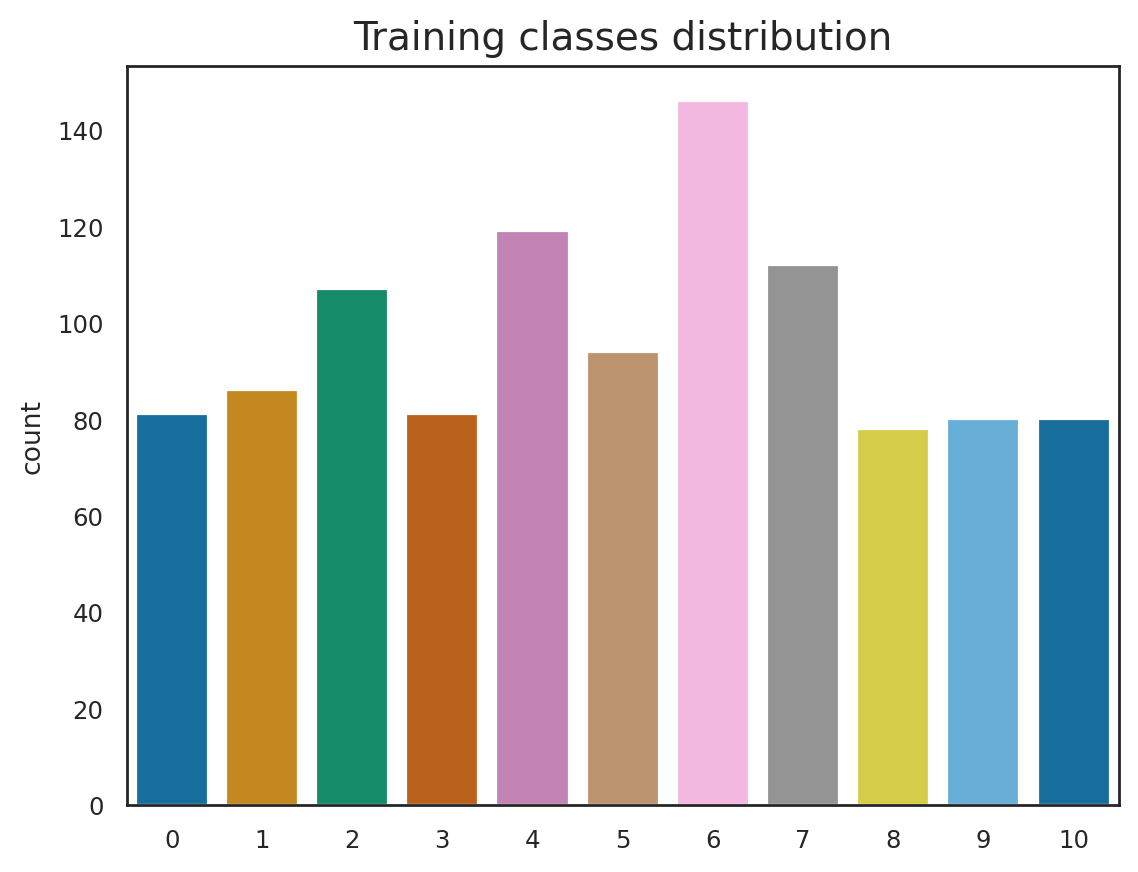

In [20]:
sns.set(context='paper', style='white')
sns.countplot(x=train_labels.numpy(), palette='colorblind')
plt.title('Training classes distribution', fontsize=14);

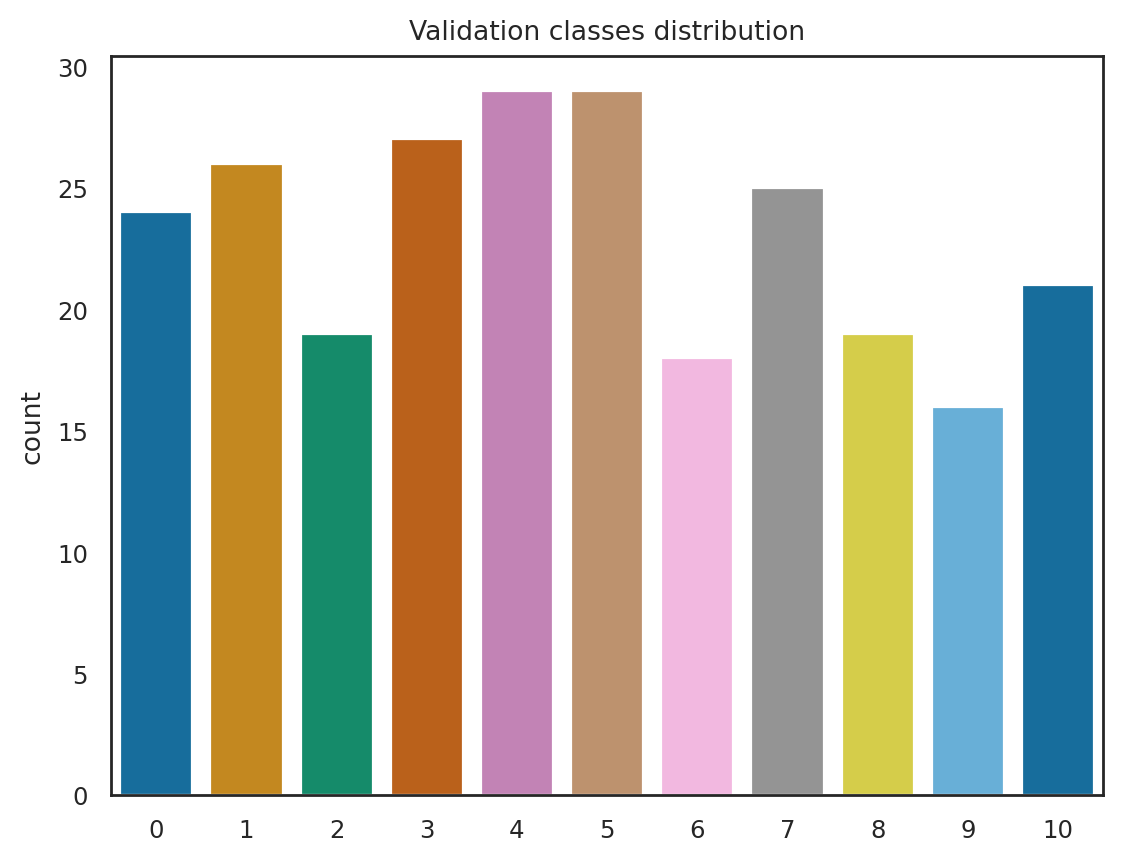

In [21]:
sns.countplot(x=validation_labels.numpy(), palette='colorblind')
plt.title('Validation classes distribution');

## Create DataLoader

In [22]:

# Define separate datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, input, reference, transform=None, transform_reference=None):
        self.input = input
        self.reference = reference
        self.transform = transform
        self.transform_reference = transform_reference
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        image = self.input[idx]
        label = self.reference[idx]
        # Apply the transform to the image

        return image, label

# Create training and validation dataset instances
train_dataset = CustomDataset(train_features, train_labels, transform=None, transform_reference=None)
val_dataset = CustomDataset(validation_features, validation_labels, transform=None, transform_reference=None)
test_dataset = CustomDataset(test_features, test_labels, transform=None, transform_reference=None)


# Create separate DataLoaders for training and validation
# train_batch_size = 16 # Adjust batch_size as needed
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data


## Define the LSTM model

See LSTM documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

![](https://drive.google.com/uc?export=view&id=1wimmf6Gt-hU1X4dMCXmVuANJAN5FM2mA)


![](https://drive.google.com/uc?export=view&id=1IFfxsTatjutdQEsiggtBGNbVL-hvZYFc)


## ConvLSTM definition.
Taken from https://github.com/ndrplz/ConvLSTM_pytorch/tree/master

In [23]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        linear_filter_size = hidden_size*2 if bidirectional==True else hidden_size
        self.fc = nn.Linear(linear_filter_size, num_classes) # *2 to account for bidirectional LSTM

    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512)

        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x) # out shape: (batch_size=1, num_frames=15, feature_size = 128*2)

        # Get hidden state of the last time step
        out = out[:, -1, :] # out shape: (batch_size=1, feature_size = 128*2)
        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        return out

In [25]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.convlstm = ConvLSTM(input_dim=512,
                 hidden_dim=self.hidden_size,
                 kernel_size=(3,3),
                 num_layers=num_layers,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)
        self.fc = nn.Linear(hidden_size, num_classes) # *2 to account for bidirectional LSTM
        self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        # x shape: (batch_size=1, num_frames=15, feature_size = 512, h=7, w=7)

        out_sequence, _ = self.convlstm(x)
        out_sequence = out_sequence[0]# out_sequence: list of 15 frames, each frame of shape: (batch_size=1, num_frames=15 feature_size = 64, h=7, w=7)

        # Get hidden state of the last time step
        out = out_sequence[:, -1, ...] # out shape: (batch_size=1, feature_size = 64, h=7, w=7)

        out = self.adaptive_avg_pool2d(out) # x shape: (batch_size=1, feature_size = 64, h=1, w=1)

        out = torch.flatten(out, start_dim=1) # x shape: (batch_size=1, num_frames=15, feature_size = 64)

        out = self.fc(out) # out shape: (batch_size=1, feature_size = 11)
        out = nn.functional.softmax(out, dim=1) # out shape: (batch_size=1, feature_size = 11)
        
        return out



## Define model parameters

In [26]:
# # Define the LSTM parameters
# input_size = train_features.shape[-1]
# num_classes = len(np.unique(train_labels))
# print(num_classes)

# # Define model parameters
# hidden_size = 128
# num_layers = 2

# # Only for LSTMClassifier
# bidirectional = False

config['input_size'] = train_features.shape[-1]
config['num_classes'] = len(np.unique(train_labels))

config

{'seed': 150,
 'train_batch_size': 64,
 'learning_rate': 0.001,
 'epochs': 100,
 'patience': 10,
 'num_frames': 15,
 'use_convlstm': True,
 'hidden_size': 64,
 'num_layers': 1,
 'step_size': 30,
 'gamma': 0.1,
 'input_size': 7,
 'num_classes': 11}

## Define the LSTM model

In [27]:
# Instantiate the LSTM model
if config['use_convlstm'] == False:
    model = LSTMClassifier(
        input_size=config['input_size'], 
        hidden_size=config['hidden_size'], 
        num_classes=config['num_classes'], 
        num_layers=config['num_layers'], 
        bidirectional=config['bidirectional']
    )
    model.to(device)
    
    print(summary(model, 
                  input_size=(config['train_batch_size'], 15, 512), 
                  col_names=('output_size', 'num_params', 'trainable'), 
                  device='cpu'))
    
elif config['use_convlstm'] == True:
    model = ConvLSTMClassifier(
        hidden_size=config['input_size'], 
        num_classes=config['num_classes'], 
        num_layers=config['num_layers']
    )
    model.to(device)
        
    print(summary(model, 
                  input_size=(config['train_batch_size'], 15, 512, 7, 7), 
                  col_names=('output_size', 'num_params', 'trainable'), 
                  device='cpu'))

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
ConvLSTMClassifier                       [64, 11]                  --                        True
├─ConvLSTM: 1-1                          [64, 15, 7, 7, 7]         --                        True
│    └─ModuleList: 2-1                   --                        --                        True
│    │    └─ConvLSTMCell: 3-1            [64, 7, 7, 7]             130,816                   True
│    │    └─ConvLSTMCell: 3-2            [64, 7, 7, 7]             (recursive)               True
│    │    └─ConvLSTMCell: 3-3            [64, 7, 7, 7]             (recursive)               True
│    │    └─ConvLSTMCell: 3-4            [64, 7, 7, 7]             (recursive)               True
│    │    └─ConvLSTMCell: 3-5            [64, 7, 7, 7]             (recursive)               True
│    │    └─ConvLSTMCell: 3-6            [64, 7, 7, 7]             (recursive)               True
│    │    └─Con

In [28]:
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

In [29]:
print_model_parameters(model)

The Model has 0.13M parameters


In [30]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:8.5f} --> {val_loss:8.5f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train

It is suggested to follow the training example from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

Use early stopping as in the aforementioned example

In [31]:
# You: Define the loss function and optimizer
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss(reduction='mean')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config['step_size'], 
                                            gamma=config['gamma'])

In [32]:
# You: Add your training logic here
def train_fn(model, dataloader, optimizer, criterion):

    scaler = torch.cuda.amp.GradScaler()  # deal with out of memory

    model.train()

    acc_metric = MulticlassAccuracy(num_classes=config['num_classes'], average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=config['num_classes'], average='macro').to(device)

    running_loss = 0.
    for images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update metrics
        running_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

        torch.cuda.empty_cache()
        _ = gc.collect()

    # Compute metrics
    acc = acc_metric.compute()
    acc_metric.reset()

    f1 = f1_metric.compute()
    f1_metric.reset()

    return running_loss / len(dataloader), acc, f1


In [33]:
@torch.no_grad()
def valid_fn(model, dataloader, criterion):

    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=config['num_classes'], average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=config['num_classes'], average='macro').to(device)

    running_loss = 0.
    for images, labels in tqdm(dataloader, leave=False):
        images = images.to(device)
        labels = labels.to(device)             

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(images)            
            loss = criterion(outputs, labels)

        # Compute metrics
        running_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

        torch.cuda.empty_cache()
        _ = gc.collect()
    
    # Compute metrics
    acc = acc_metric.compute()
    acc_metric.reset()

    f1 = f1_metric.compute()
    f1_metric.reset()

    return running_loss / len(dataloader), acc, f1

In [34]:
%%time

t0 = time.time()

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=config['patience'], verbose=True)
history = {
    'train_loss': [],
    'train_acc' : [],
    'train_f1'  : [],
    'valid_loss': [],
    'valid_acc' : [],
    'valid_f1'  : []
}
for epoch in trange(config['epochs']):

    train_loss, train_acc, train_f1 = train_fn(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = valid_fn(model, valid_loader, criterion)

    print(f"Epoch: {epoch + 1:>03}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    print(f'train loss: {train_loss:8.5f} | train acc: {train_acc:8.5f} | train f1 score: {train_f1:8.5f} | '
          f'val loss: {valid_loss:8.5f} | val acc: {valid_acc:8.5f} | val f1 score: {valid_f1:8.5f}')
    
    if scheduler is not None:
        scheduler.step()

    # Early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    history['train_loss'].append(train_loss)
    history['train_acc' ].append(train_acc.detach().cpu())
    history['train_f1'  ].append(train_f1.detach().cpu())
    history['valid_loss'].append(valid_loss)
    history['valid_acc' ].append(valid_acc.detach().cpu())
    history['valid_f1'  ].append(valid_f1.detach().cpu())

    if early_stopping.early_stop:
        print("Early stopping")
        break

print(f"\nExecution time: {time.time() - t0:.5f}\n")

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 001, Learning Rate: 0.001
train loss:  2.36181 | train acc:  0.24631 | train f1 score:  0.17549 | val loss:  2.34980 | val acc:  0.26332 | val f1 score:  0.15993
Validation loss decreased (     inf -->  2.34980).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 002, Learning Rate: 0.001
train loss:  2.32449 | train acc:  0.36331 | train f1 score:  0.28885 | val loss:  2.33499 | val acc:  0.31294 | val f1 score:  0.22405
Validation loss decreased ( 2.34980 -->  2.33499).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 003, Learning Rate: 0.001
train loss:  2.30043 | train acc:  0.39367 | train f1 score:  0.31182 | val loss:  2.31659 | val acc:  0.36797 | val f1 score:  0.25783
Validation loss decreased ( 2.33499 -->  2.31659).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 004, Learning Rate: 0.001
train loss:  2.27334 | train acc:  0.46069 | train f1 score:  0.39948 | val loss:  2.29864 | val acc:  0.45979 | val f1 score:  0.37278
Validation loss decreased ( 2.31659 -->  2.29864).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 005, Learning Rate: 0.001
train loss:  2.25187 | train acc:  0.51386 | train f1 score:  0.47176 | val loss:  2.28573 | val acc:  0.42898 | val f1 score:  0.35629
Validation loss decreased ( 2.29864 -->  2.28573).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 006, Learning Rate: 0.001
train loss:  2.23175 | train acc:  0.52657 | train f1 score:  0.48645 | val loss:  2.27065 | val acc:  0.47989 | val f1 score:  0.39634
Validation loss decreased ( 2.28573 -->  2.27065).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 007, Learning Rate: 0.001
train loss:  2.20939 | train acc:  0.57629 | train f1 score:  0.53571 | val loss:  2.25281 | val acc:  0.51718 | val f1 score:  0.44233
Validation loss decreased ( 2.27065 -->  2.25281).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 008, Learning Rate: 0.001
train loss:  2.18359 | train acc:  0.62298 | train f1 score:  0.59440 | val loss:  2.24058 | val acc:  0.57345 | val f1 score:  0.48854
Validation loss decreased ( 2.25281 -->  2.24058).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 009, Learning Rate: 0.001
train loss:  2.15540 | train acc:  0.66333 | train f1 score:  0.63901 | val loss:  2.22367 | val acc:  0.64128 | val f1 score:  0.55830
Validation loss decreased ( 2.24058 -->  2.22367).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 010, Learning Rate: 0.001
train loss:  2.14110 | train acc:  0.68502 | train f1 score:  0.65953 | val loss:  2.19893 | val acc:  0.59075 | val f1 score:  0.49925
Validation loss decreased ( 2.22367 -->  2.19893).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 011, Learning Rate: 0.001
train loss:  2.11463 | train acc:  0.70885 | train f1 score:  0.68336 | val loss:  2.18307 | val acc:  0.63402 | val f1 score:  0.54329
Validation loss decreased ( 2.19893 -->  2.18307).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 012, Learning Rate: 0.001
train loss:  2.09767 | train acc:  0.75768 | train f1 score:  0.73197 | val loss:  2.17650 | val acc:  0.60599 | val f1 score:  0.49910
Validation loss decreased ( 2.18307 -->  2.17650).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 013, Learning Rate: 0.001
train loss:  2.07529 | train acc:  0.75929 | train f1 score:  0.73185 | val loss:  2.16361 | val acc:  0.64182 | val f1 score:  0.54336
Validation loss decreased ( 2.17650 -->  2.16361).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 014, Learning Rate: 0.001
train loss:  2.05018 | train acc:  0.78861 | train f1 score:  0.76052 | val loss:  2.14150 | val acc:  0.64372 | val f1 score:  0.56541
Validation loss decreased ( 2.16361 -->  2.14150).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 015, Learning Rate: 0.001
train loss:  2.02840 | train acc:  0.79738 | train f1 score:  0.76716 | val loss:  2.12237 | val acc:  0.68097 | val f1 score:  0.60853
Validation loss decreased ( 2.14150 -->  2.12237).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 016, Learning Rate: 0.001
train loss:  2.00477 | train acc:  0.82266 | train f1 score:  0.79165 | val loss:  2.11703 | val acc:  0.66872 | val f1 score:  0.59039
Validation loss decreased ( 2.12237 -->  2.11703).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 017, Learning Rate: 0.001
train loss:  1.98395 | train acc:  0.83238 | train f1 score:  0.80248 | val loss:  2.10224 | val acc:  0.68816 | val f1 score:  0.61168
Validation loss decreased ( 2.11703 -->  2.10224).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 018, Learning Rate: 0.001
train loss:  1.96339 | train acc:  0.84683 | train f1 score:  0.81585 | val loss:  2.09746 | val acc:  0.68031 | val f1 score:  0.61925
Validation loss decreased ( 2.10224 -->  2.09746).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 019, Learning Rate: 0.001
train loss:  1.95549 | train acc:  0.83799 | train f1 score:  0.80612 | val loss:  2.08476 | val acc:  0.67463 | val f1 score:  0.59516
Validation loss decreased ( 2.09746 -->  2.08476).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 020, Learning Rate: 0.001
train loss:  1.93411 | train acc:  0.84907 | train f1 score:  0.82078 | val loss:  2.06457 | val acc:  0.70444 | val f1 score:  0.63695
Validation loss decreased ( 2.08476 -->  2.06457).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 021, Learning Rate: 0.001
train loss:  1.92194 | train acc:  0.85825 | train f1 score:  0.83049 | val loss:  2.05817 | val acc:  0.68358 | val f1 score:  0.60900
Validation loss decreased ( 2.06457 -->  2.05817).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 022, Learning Rate: 0.001
train loss:  1.89777 | train acc:  0.86568 | train f1 score:  0.83653 | val loss:  2.06277 | val acc:  0.69541 | val f1 score:  0.63232
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 023, Learning Rate: 0.001
train loss:  1.88183 | train acc:  0.87002 | train f1 score:  0.84055 | val loss:  2.04165 | val acc:  0.69709 | val f1 score:  0.63410
Validation loss decreased ( 2.05817 -->  2.04165).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 024, Learning Rate: 0.001
train loss:  1.86667 | train acc:  0.87354 | train f1 score:  0.84378 | val loss:  2.03259 | val acc:  0.70810 | val f1 score:  0.63791
Validation loss decreased ( 2.04165 -->  2.03259).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 025, Learning Rate: 0.001
train loss:  1.85354 | train acc:  0.88082 | train f1 score:  0.85048 | val loss:  2.03418 | val acc:  0.70330 | val f1 score:  0.62561
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 026, Learning Rate: 0.001
train loss:  1.84808 | train acc:  0.87521 | train f1 score:  0.84430 | val loss:  2.03757 | val acc:  0.69928 | val f1 score:  0.62091
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 027, Learning Rate: 0.001
train loss:  1.85606 | train acc:  0.85983 | train f1 score:  0.82914 | val loss:  2.03650 | val acc:  0.69378 | val f1 score:  0.64573
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 028, Learning Rate: 0.001
train loss:  1.84256 | train acc:  0.87752 | train f1 score:  0.84701 | val loss:  2.02404 | val acc:  0.68688 | val f1 score:  0.63103
Validation loss decreased ( 2.03259 -->  2.02404).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 029, Learning Rate: 0.001
train loss:  1.81532 | train acc:  0.88469 | train f1 score:  0.85371 | val loss:  2.01539 | val acc:  0.69298 | val f1 score:  0.64331
Validation loss decreased ( 2.02404 -->  2.01539).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 030, Learning Rate: 0.001
train loss:  1.80733 | train acc:  0.88541 | train f1 score:  0.85383 | val loss:  2.00209 | val acc:  0.69665 | val f1 score:  0.62714
Validation loss decreased ( 2.01539 -->  2.00209).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 031, Learning Rate: 0.0001
train loss:  1.79368 | train acc:  0.88534 | train f1 score:  0.85387 | val loss:  1.98912 | val acc:  0.71346 | val f1 score:  0.65779
Validation loss decreased ( 2.00209 -->  1.98912).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 032, Learning Rate: 0.0001
train loss:  1.78698 | train acc:  0.88968 | train f1 score:  0.85816 | val loss:  1.98693 | val acc:  0.69176 | val f1 score:  0.63002
Validation loss decreased ( 1.98912 -->  1.98693).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 033, Learning Rate: 0.0001
train loss:  1.78394 | train acc:  0.89064 | train f1 score:  0.85875 | val loss:  1.98664 | val acc:  0.70512 | val f1 score:  0.64615
Validation loss decreased ( 1.98693 -->  1.98664).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 034, Learning Rate: 0.0001
train loss:  1.78362 | train acc:  0.89064 | train f1 score:  0.85871 | val loss:  1.98590 | val acc:  0.69360 | val f1 score:  0.63562
Validation loss decreased ( 1.98664 -->  1.98590).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 035, Learning Rate: 0.0001
train loss:  1.78246 | train acc:  0.89064 | train f1 score:  0.85890 | val loss:  1.98574 | val acc:  0.70512 | val f1 score:  0.64591
Validation loss decreased ( 1.98590 -->  1.98574).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 036, Learning Rate: 0.0001
train loss:  1.78122 | train acc:  0.89064 | train f1 score:  0.85898 | val loss:  1.98582 | val acc:  0.70198 | val f1 score:  0.64065
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 037, Learning Rate: 0.0001
train loss:  1.77890 | train acc:  0.89064 | train f1 score:  0.85854 | val loss:  1.98596 | val acc:  0.70654 | val f1 score:  0.64868
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 038, Learning Rate: 0.0001
train loss:  1.77865 | train acc:  0.89064 | train f1 score:  0.85862 | val loss:  1.98426 | val acc:  0.68644 | val f1 score:  0.62625
Validation loss decreased ( 1.98574 -->  1.98426).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 039, Learning Rate: 0.0001
train loss:  1.77827 | train acc:  0.89064 | train f1 score:  0.85898 | val loss:  1.98459 | val acc:  0.70317 | val f1 score:  0.64409
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 040, Learning Rate: 0.0001
train loss:  1.77425 | train acc:  0.89064 | train f1 score:  0.85844 | val loss:  1.98532 | val acc:  0.69796 | val f1 score:  0.63801
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 041, Learning Rate: 0.0001
train loss:  1.77414 | train acc:  0.89064 | train f1 score:  0.85891 | val loss:  1.98307 | val acc:  0.70133 | val f1 score:  0.64389
Validation loss decreased ( 1.98426 -->  1.98307).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 042, Learning Rate: 0.0001
train loss:  1.77229 | train acc:  0.89064 | train f1 score:  0.85840 | val loss:  1.98488 | val acc:  0.70654 | val f1 score:  0.64914
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 043, Learning Rate: 0.0001
train loss:  1.77114 | train acc:  0.89064 | train f1 score:  0.85857 | val loss:  1.98279 | val acc:  0.70133 | val f1 score:  0.64358
Validation loss decreased ( 1.98307 -->  1.98279).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 044, Learning Rate: 0.0001
train loss:  1.77107 | train acc:  0.89064 | train f1 score:  0.85877 | val loss:  1.98374 | val acc:  0.70087 | val f1 score:  0.64756
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 045, Learning Rate: 0.0001
train loss:  1.76937 | train acc:  0.89161 | train f1 score:  0.85978 | val loss:  1.98222 | val acc:  0.70446 | val f1 score:  0.64551
Validation loss decreased ( 1.98279 -->  1.98222).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 046, Learning Rate: 0.0001
train loss:  1.76837 | train acc:  0.89355 | train f1 score:  0.86154 | val loss:  1.98318 | val acc:  0.69608 | val f1 score:  0.64407
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 047, Learning Rate: 0.0001
train loss:  1.76815 | train acc:  0.89355 | train f1 score:  0.86170 | val loss:  1.98133 | val acc:  0.69945 | val f1 score:  0.64255
Validation loss decreased ( 1.98222 -->  1.98133).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 048, Learning Rate: 0.0001
train loss:  1.76757 | train acc:  0.89355 | train f1 score:  0.86176 | val loss:  1.98088 | val acc:  0.70611 | val f1 score:  0.64618
Validation loss decreased ( 1.98133 -->  1.98088).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 049, Learning Rate: 0.0001
train loss:  1.76645 | train acc:  0.89355 | train f1 score:  0.86191 | val loss:  1.97997 | val acc:  0.69750 | val f1 score:  0.64297
Validation loss decreased ( 1.98088 -->  1.97997).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 050, Learning Rate: 0.0001
train loss:  1.76569 | train acc:  0.89355 | train f1 score:  0.86166 | val loss:  1.98024 | val acc:  0.69608 | val f1 score:  0.63940
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 051, Learning Rate: 0.0001
train loss:  1.76366 | train acc:  0.89355 | train f1 score:  0.86171 | val loss:  1.98023 | val acc:  0.69581 | val f1 score:  0.64003
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 052, Learning Rate: 0.0001
train loss:  1.76343 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97981 | val acc:  0.69960 | val f1 score:  0.64756
Validation loss decreased ( 1.97997 -->  1.97981).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 053, Learning Rate: 0.0001
train loss:  1.76250 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97903 | val acc:  0.69723 | val f1 score:  0.64213
Validation loss decreased ( 1.97981 -->  1.97903).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 054, Learning Rate: 0.0001
train loss:  1.76102 | train acc:  0.89548 | train f1 score:  0.86345 | val loss:  1.97911 | val acc:  0.69987 | val f1 score:  0.64679
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 055, Learning Rate: 0.0001
train loss:  1.76037 | train acc:  0.89548 | train f1 score:  0.86345 | val loss:  1.97866 | val acc:  0.69287 | val f1 score:  0.64170
Validation loss decreased ( 1.97903 -->  1.97866).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 056, Learning Rate: 0.0001
train loss:  1.75879 | train acc:  0.89548 | train f1 score:  0.86358 | val loss:  1.97778 | val acc:  0.69736 | val f1 score:  0.64262
Validation loss decreased ( 1.97866 -->  1.97778).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 057, Learning Rate: 0.0001
train loss:  1.75706 | train acc:  0.89548 | train f1 score:  0.86332 | val loss:  1.97750 | val acc:  0.70102 | val f1 score:  0.64974
Validation loss decreased ( 1.97778 -->  1.97750).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 058, Learning Rate: 0.0001
train loss:  1.75608 | train acc:  0.89548 | train f1 score:  0.86345 | val loss:  1.97746 | val acc:  0.70129 | val f1 score:  0.64985
Validation loss decreased ( 1.97750 -->  1.97746).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 059, Learning Rate: 0.0001
train loss:  1.75602 | train acc:  0.89548 | train f1 score:  0.86364 | val loss:  1.97678 | val acc:  0.69287 | val f1 score:  0.64135
Validation loss decreased ( 1.97746 -->  1.97678).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 060, Learning Rate: 0.0001
train loss:  1.75552 | train acc:  0.89548 | train f1 score:  0.86364 | val loss:  1.97560 | val acc:  0.70102 | val f1 score:  0.64861
Validation loss decreased ( 1.97678 -->  1.97560).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 061, Learning Rate: 1e-05
train loss:  1.75431 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97561 | val acc:  0.70102 | val f1 score:  0.64905
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 062, Learning Rate: 1e-05
train loss:  1.75470 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97552 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97560 -->  1.97552).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 063, Learning Rate: 1e-05
train loss:  1.75401 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97564 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 064, Learning Rate: 1e-05
train loss:  1.75488 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97568 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 065, Learning Rate: 1e-05
train loss:  1.75344 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97557 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 066, Learning Rate: 1e-05
train loss:  1.75437 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97546 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97552 -->  1.97546).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 067, Learning Rate: 1e-05
train loss:  1.75407 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97542 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97546 -->  1.97542).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 068, Learning Rate: 1e-05
train loss:  1.75283 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97550 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 069, Learning Rate: 1e-05
train loss:  1.75447 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97529 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97542 -->  1.97529).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 070, Learning Rate: 1e-05
train loss:  1.75340 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97533 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 071, Learning Rate: 1e-05
train loss:  1.75310 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97524 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97529 -->  1.97524).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 072, Learning Rate: 1e-05
train loss:  1.75524 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97528 | val acc:  0.69765 | val f1 score:  0.64710
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 073, Learning Rate: 1e-05
train loss:  1.75188 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97513 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97524 -->  1.97513).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 074, Learning Rate: 1e-05
train loss:  1.75707 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97509 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97513 -->  1.97509).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 075, Learning Rate: 1e-05
train loss:  1.75525 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97505 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97509 -->  1.97505).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 076, Learning Rate: 1e-05
train loss:  1.75321 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97498 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97505 -->  1.97498).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 077, Learning Rate: 1e-05
train loss:  1.75333 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97486 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97498 -->  1.97486).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 078, Learning Rate: 1e-05
train loss:  1.75277 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97476 | val acc:  0.69765 | val f1 score:  0.64710
Validation loss decreased ( 1.97486 -->  1.97476).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 079, Learning Rate: 1e-05
train loss:  1.75348 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97474 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97476 -->  1.97474).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 080, Learning Rate: 1e-05
train loss:  1.75163 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97463 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97474 -->  1.97463).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 081, Learning Rate: 1e-05
train loss:  1.75376 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97458 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97463 -->  1.97458).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 082, Learning Rate: 1e-05
train loss:  1.75128 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97449 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97458 -->  1.97449).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 083, Learning Rate: 1e-05
train loss:  1.75344 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97439 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97449 -->  1.97439).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 084, Learning Rate: 1e-05
train loss:  1.75297 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97440 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 085, Learning Rate: 1e-05
train loss:  1.75166 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97422 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97439 -->  1.97422).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 086, Learning Rate: 1e-05
train loss:  1.75323 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97419 | val acc:  0.70465 | val f1 score:  0.65217
Validation loss decreased ( 1.97422 -->  1.97419).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 087, Learning Rate: 1e-05
train loss:  1.75265 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97411 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97419 -->  1.97411).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 088, Learning Rate: 1e-05
train loss:  1.75182 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97407 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97411 -->  1.97407).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 089, Learning Rate: 1e-05
train loss:  1.75204 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97397 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97407 -->  1.97397).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 090, Learning Rate: 1e-05
train loss:  1.75107 | train acc:  0.89548 | train f1 score:  0.86367 | val loss:  1.97386 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97397 -->  1.97386).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 091, Learning Rate: 1.0000000000000002e-06
train loss:  1.75101 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97386 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97386 -->  1.97386).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 092, Learning Rate: 1.0000000000000002e-06
train loss:  1.75167 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97386 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 093, Learning Rate: 1.0000000000000002e-06
train loss:  1.75224 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97388 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 2 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 094, Learning Rate: 1.0000000000000002e-06
train loss:  1.75251 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97387 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 3 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 095, Learning Rate: 1.0000000000000002e-06
train loss:  1.75066 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97386 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 4 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 096, Learning Rate: 1.0000000000000002e-06
train loss:  1.75155 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97385 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97386 -->  1.97385).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 097, Learning Rate: 1.0000000000000002e-06
train loss:  1.75093 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97384 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97385 -->  1.97384).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 098, Learning Rate: 1.0000000000000002e-06
train loss:  1.75091 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97385 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 1 out of 10


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 099, Learning Rate: 1.0000000000000002e-06
train loss:  1.75224 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97384 | val acc:  0.70102 | val f1 score:  0.64995
Validation loss decreased ( 1.97384 -->  1.97384).  Saving model ...


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 100, Learning Rate: 1.0000000000000002e-06
train loss:  1.75177 | train acc:  0.89548 | train f1 score:  0.86371 | val loss:  1.97384 | val acc:  0.70102 | val f1 score:  0.64995
EarlyStopping counter: 1 out of 10

Execution time: 5240.62571

CPU times: user 1h 33min 33s, sys: 1min 41s, total: 1h 35min 15s
Wall time: 1h 27min 20s


<All keys matched successfully>

## Plot the training and validation loss

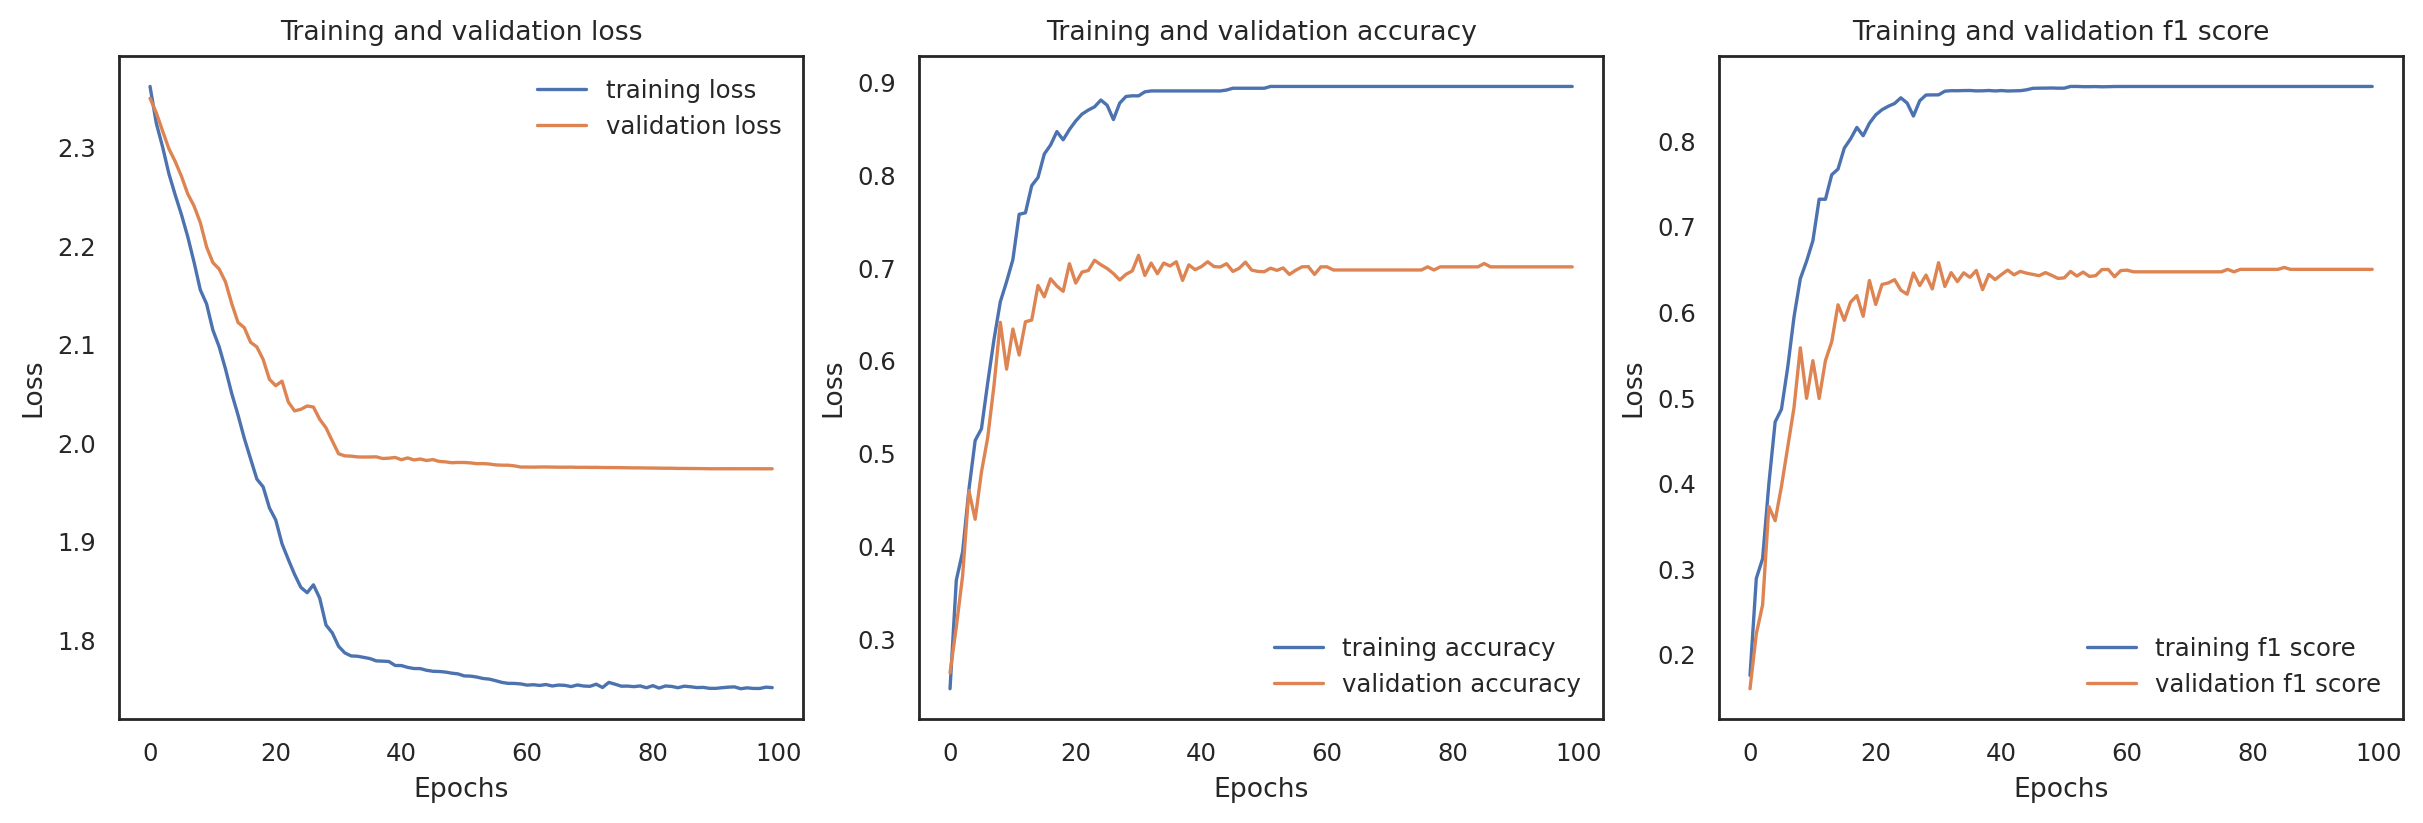

In [35]:
# You: Plot the training and validation loss
# visualize the loss as the network trained
fig, ax = plt.subplots(1, 3, figsize=[12, 4], layout='constrained')

ax[0].plot(range(epoch + 1), history['train_loss'], label='training loss')
ax[0].plot(range(epoch + 1), history['valid_loss'], label='validation loss')
ax[0].set(xlabel='Epochs', ylabel='Loss', title='Training and validation loss')

ax[1].plot(range(epoch + 1), history['train_acc'], label='training accuracy')
ax[1].plot(range(epoch + 1), history['valid_acc'], label='validation accuracy')
ax[1].set(xlabel='Epochs', ylabel='Loss', title='Training and validation accuracy')

ax[2].plot(range(epoch + 1), history['train_f1'], label='training f1 score')
ax[2].plot(range(epoch + 1), history['valid_f1'], label='validation f1 score')
ax[2].set(xlabel='Epochs', ylabel='Loss', title='Training and validation f1 score')

[ax[ii].legend(frameon=False) for ii in range(3)];

## See a sample video prediction

ic| idx: 65


Classified as ['biking'], corresponding to class ID 1
Reference is ['biking'], corresponding to class ID 1



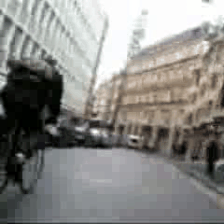

In [36]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    return embed.embed_file('./animation.gif')


idx = np.random.randint(0, test_features.shape[0]) # For good results, you can try IDs 348, 72
ic(idx)

sample_video = load_video(video_paths_test[idx])[:100]

# Make prediction on sample test video
prediction = model(test_features[idx].unsqueeze(0).cuda())
prediction = np.squeeze(prediction)
prediction = prediction.cpu().detach().numpy().argmax(axis=0)

# ic(prediction.shape)
# ic(prediction.argmax(axis=0))
# ic(test_labels[idx])
classes=['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding',
       'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping',
       'volleyball_spiking', 'walking']


print(f"Classified as {le.inverse_transform(np.array([prediction]))}, corresponding to class ID {prediction}")
print(f"Reference is {le.inverse_transform(np.array([test_labels[idx]]))}, corresponding to class ID {test_labels[idx]}")

# Display sample test video
to_gif(sample_video)

## Calculate test metrics

Overall accuracy: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

Average F1-Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [37]:
@torch.no_grad()
def eval_fn(model, dataloader):
    
    model.eval()

    y_pred = torch.tensor([], device=device)
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs, dim=1)
        y_pred = torch.cat([y_pred, preds], dim=0)
        
    return y_pred.detach().cpu()


In [38]:
%%time

y_pred = eval_fn(model, test_loader)

  0%|          | 0/332 [00:00<?, ?it/s]

CPU times: user 3.47 s, sys: 6.99 ms, total: 3.48 s
Wall time: 1.74 s


In [39]:
%%time
# You: Calculate test metrics
# Hint: Reference is in the variable "test_labels"

test_acc = accuracy_score(test_labels, y_pred)
test_f1 = f1_score(test_labels, y_pred, average='macro')

print(f'Testing accuracy: {test_acc:.5f} and f1 score: {test_f1:.5f}\n')

Testing accuracy: 0.70783 and f1 score: 0.65271

CPU times: user 3.15 ms, sys: 2.99 ms, total: 6.14 ms
Wall time: 6.79 ms


In [40]:
print(classification_report(test_labels, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

        basketball       0.58      0.45      0.51        33
            biking       0.71      0.91      0.80        33
            diving       0.90      0.87      0.88        30
        golf_swing       0.67      0.76      0.71        34
      horse_riding       0.82      0.90      0.86        50
   soccer_juggling       0.64      0.55      0.59        33
             swing       0.80      0.96      0.87        25
      tennis_swing       0.62      0.87      0.72        30
trampoline_jumping       0.36      0.36      0.36        22
volleyball_spiking       0.89      0.85      0.87        20
           walking       0.00      0.00      0.00        22

          accuracy                           0.71       332
         macro avg       0.64      0.68      0.65       332
      weighted avg       0.66      0.71      0.68       332



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


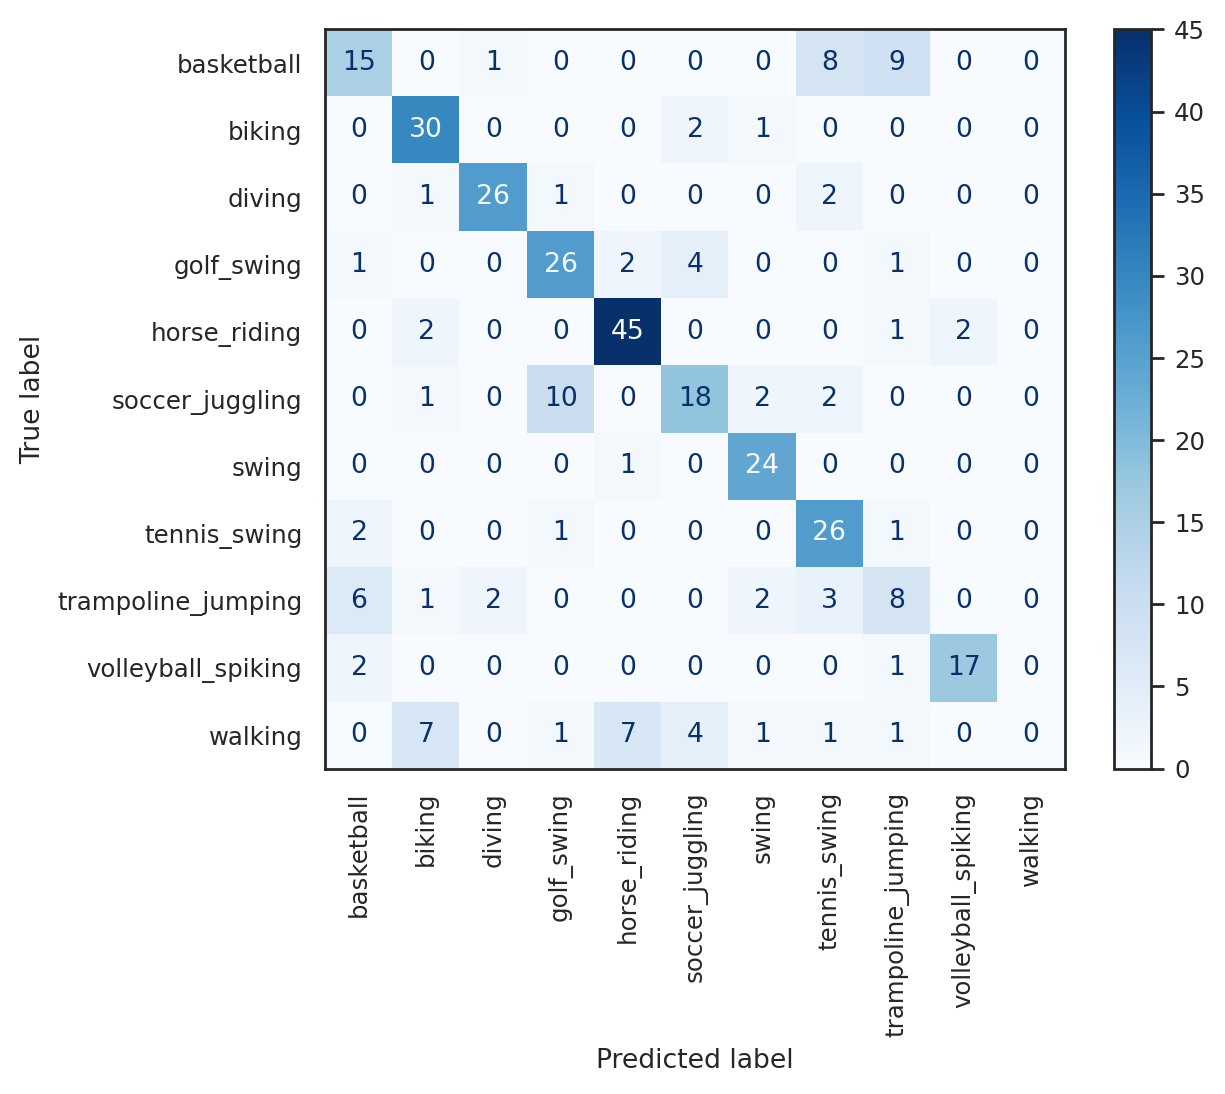

In [41]:
_ = ConfusionMatrixDisplay.from_predictions(
    test_labels, y_pred, cmap='Blues', display_labels=target_names, xticks_rotation='vertical'
)